<h1 align="center">INFO621 - RAG Project XAI - Mistral DPO tune & Compare </h1>

### DPO tuned model saved here : https://huggingface.co/sauravverma78/mistral7bInstruct02_fever_dpo

### DPO tuning Accuracy 70% compared to PEFT 73%, base mistral RAG is 56%



## This notebook / code was developed on COLAB - A100 GPU.

### The code here uses performs DPO tuning atop a Peft tuned MISTRAL 7B and evaluate RAG pipeline with tuned DPO model
- We fine-tuned Mistral using Direct Preference Optimization (DPO) from the TRL library.

- For this, we generated ~1,000 response pairs: each with a "chosen" (correct) and "rejected" (plausible but incorrect) output for the same prompt. The incorrect responses were LLM-generated to mimic common errors.
- We applied DPO loss using the same hyperparameters as LoRA tuning (5×10-4 LR, 2 epochs), training on the same hardware setup.

-  This allowed us to compare supervised fine-tuning with preference-based alignment under controlledconditions.

### Other Notes

- Refer README.md for more details.
- And the Project report for combined study and analysis

- Steps are mentioned in README.md.
    -  Execute the Next cell for pip installs. 
    -  This install all packages required on COLAB
    -  **Note : During package install, Colab would ask for "restart" of session. Please do so. And run the install cell again.**
    -  Requires access to your local google drive.
    -  Would need your HuggingFace Token (to download the models)

    -  change `hub_save_path = ` below if you want to save tuned model to your huggingFace cloud.
    


#### Some steps take a long time to run, 
- We suggest running cell by cell manually to see the executions, as some steps are time consuming

### The code here uses Mistral-7B model and trl, peft modules for PEFT Tuning.
- Refer README.md for more details.
- And the Project report for combined study and analysis


### Core Libraries used in the project
 - **Core-ML/NLP**: torch, transformers, accelerate, bitsandbytes, sentence-transformers.
 - **Fine-Tuning**: peft, trl [PART OF ANOTHER NOTEBOOK]
 - **RAG & Vector Store**: langchain, chromadb, faiss-gpu
 - **Evaluation**: scikit-learn, **RAGAS**
 - **XAI**: captum, lime, shap, ,lit
 - **Data Handling**: datasets, numpy
 - **Utilities**: tqdm, psutil, asyncio, nest_asyncio, openai, tiktoken, matplotlib, seaborn

In [1]:
# RUN FOR COLAB

!pip install accelerate==1.6.0
!pip install transformers==4.51.3
!pip install datasets==3.5.1
!pip install sentence-transformers==3.4.1
!pip install langchain


!pip install langchain-community
!pip install langchainhub
!pip install chromadb==1.0.5
!pip install openai


# Fine Tuning
!pip install peft==0.8.2
!pip install bitsandbytes
!pip install loralib
!pip install rank_bm25

# trl==0.18.0 install required for DPO
!pip install git+https://github.com/huggingface/trl.git@main


  Cloning https://github.com/huggingface/trl.git (to revision main) to /tmp/pip-req-build-j04n7hc3
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/trl.git /tmp/pip-req-build-j04n7hc3
  Resolved https://github.com/huggingface/trl.git to commit cafa663c840cff0603ec427f7500fff1af54b072
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
#  Standard Library
import os
import re
import gc
import time
import asyncio
import warnings
from typing import List, Optional, Any
from collections import Counter
import numpy as np

#  Visualization
import matplotlib
import matplotlib.pyplot as plt

from IPython.display import display, HTML

# Scientific & ML Libraries
import numpy as np
import torch
from torch.nn import functional as F
import seaborn as sns
from tqdm import tqdm
import psutil
# import shap
# from lime.lime_text import LimeTextExplainer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity

#  Transformers / HuggingFace
import accelerate
import bitsandbytes as bnb
from transformers import (
    pipeline, AutoTokenizer, AutoModelForCausalLM,
    AutoModelForSeq2SeqLM, GenerationConfig, TrainingArguments,
    BitsAndBytesConfig
)
from sentence_transformers import SentenceTransformer
# from captum.attr import Saliency, IntegratedGradients
# from captum.attr import visualization as viz

#  LangChain Core
from langchain.prompts import PromptTemplate
from langchain.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings
# from langchain.llms import HuggingFacePipeline
from langchain.chains import RetrievalQA
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain.llms.base import LLM
from langchain.schema import LLMResult, Document
from langchain.callbacks.base import BaseCallbackHandler
from langchain.callbacks.tracers import ConsoleCallbackHandler
from langchain.callbacks.manager import CallbackManager, CallbackManagerForLLMRun
from langchain.chat_models import ChatOpenAI
from langchain.schema.retriever import BaseRetriever

#  LangChain Community Extensions
# from langchain_huggingface import HuggingFacePipeline, HuggingFaceEmbeddings
from langchain_community.llms import HuggingFacePipeline
from langchain_community.embeddings import HuggingFaceEmbeddings

#  LangChain Core v1-style
from langchain_core.retrievers import BaseRetriever as LCBaseRetriever
from langchain_core.documents import Document as LCDocument
from langchain_core.pydantic_v1 import Field


#  Datasets
from datasets import Dataset, load_dataset

#  Notebook Setup
import nest_asyncio
nest_asyncio.apply()

# Fine Tuning
from trl import SFTTrainer, SFTConfig
from peft import LoraConfig, get_peft_model

#  Suppress Warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", message="Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.")


/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3553: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
import torch
torch.cuda.is_available()

True

In [4]:
colab_mode = True
local_mode = False
local_path = None
hub_load_path = "sauravverma78/mistral7bInstruct02_fever_trained"
hub_save_path = "sauravverma78/mistral7bInstruct02_fever_dpo"

In [5]:
if (colab_mode):
    from google.colab import drive
    drive.mount('/content/drive')
    local_path = "/content/drive/MyDrive/models"
elif local_mode:

    # Adjust according to your host.
    local_path = '/Users/saurav1/python/masters/arizona/2nd/mlapps621/project/local_models'


Mounted at /content/drive


In [6]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: fineGrained).
The token `test` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `test`


In [7]:
from langchain.callbacks.manager import CallbackManager

# Langchain callback for detailed logging
CALLBACK_VERBOSE_LOGGING=True



## ==== 1) Load FEVER Dataset ====

In [8]:
# dataset1 = load_dataset("fever/feverous")
dataset1 = load_dataset("copenlu/fever_gold_evidence")

README.md:   0%|          | 0.00/5.19k [00:00<?, ?B/s]

train.jsonl:   0%|          | 0.00/96.9M [00:00<?, ?B/s]

valid.jsonl:   0%|          | 0.00/6.47M [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/6.63M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/228277 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/15935 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/16039 [00:00<?, ? examples/s]

In [9]:
dataset1

DatasetDict({
    train: Dataset({
        features: ['claim', 'label', 'evidence', 'id', 'verifiable', 'original_id'],
        num_rows: 228277
    })
    validation: Dataset({
        features: ['claim', 'label', 'evidence', 'id', 'verifiable', 'original_id'],
        num_rows: 15935
    })
    test: Dataset({
        features: ['claim', 'label', 'evidence', 'id', 'verifiable', 'original_id'],
        num_rows: 16039
    })
})

In [10]:
train = dataset1['train']
validation = dataset1['validation']
test = dataset1['test']

## ==== 2) Cleaned FEVER Dataset ====

####  For the preprocessing of the dataset we manage to remove:

- all words after the last dot (they don't belong to the sentence but are a kind of most relevant terms) ------> ?????
- all the digits that we found at the beginning of the sentence (also with the tab)
- all the parenthesis token strings
- all the words that contains characters that are not in ASCII format (for example the ones retrieved by the Wikipedia page for the pronunciation of a given name or term)
- all the punctuation


In [11]:


# Special tokens like "-LRB-" etc.
PARENTHESIS_TOKENS = {"-LRB-", "-LSB-", "-RRB-", "-RSB-"}

# Check for non-ASCII characters
def contains_non_ascii(s):
    return any(ord(ch) > 127 for ch in s)

# Remove parenthesis tokens
def remove_parenthesis(sentence):
    return ' '.join([word for word in sentence.split() if word not in PARENTHESIS_TOKENS])

# Clean up a single sentence
def clean_sentence(sentence):
    if not isinstance(sentence, str):
        return ""

    # 1. Remove trailing fragments after first period (optional)
    sentence = re.sub(r'(\.[^.]*)$', '.', sentence)

    # 2. Remove leading digits + tab
    sentence = re.sub(r'^\d+\t', '', sentence)

    # 3. Remove special parenthesis tokens like -LRB-, -RRB-, etc.
    sentence = re.sub(r'-LRB-|-RRB-|-LSB-|-RSB-', '', sentence)

    # 4. Remove words with non-ASCII characters
    words = sentence.split()
    words = [word for word in words if all(ord(ch) < 128 for ch in word)]
    sentence = ' '.join(words)

    # 5. Remove punctuation and underscores but KEEP dots and commas
    sentence = re.sub(r'[^\w\s.,]', '', sentence)

    # 6. Normalize whitespace
    sentence = re.sub(r'\s+', ' ', sentence)

    sentence = re.sub(r'[^\w\s.,]', '', sentence)
    sentence = re.sub(r'[_]', ' ', sentence)

    # 7. Lowercase
    sentence = sentence.lower().strip()
    if not (sentence.endswith(".")):
        sentence +=  "."
    return sentence

In [12]:
# === Extract and Clean Evidence Sentences ===
def clean_evidences(ds, dedup = True, max_len=500, typ="train"):
    evidence_sentences = []
    total = 0
    for example in ds:
        if 'evidence' in example and example['evidence']:
            total += 1
            for group in example['evidence']:
                full_sent = ""
                for ev in group:
                    if isinstance(ev, str) and not ev.isdigit():
                        sentence = clean_sentence(ev)
                        if sentence:
                            full_sent += sentence + " "
                if full_sent.strip():
                    evidence_sentences.append(full_sent.strip()[0:max_len])

    # Deduplicate
    if dedup:
      evidence_sentences = list(set(evidence_sentences))
    print("total ", total)
    print(f"Total cleaned evidence dedup sentences : {len(evidence_sentences)}, of {typ}")
    for e in evidence_sentences[:2]:
        print("Sample:", e)
    return evidence_sentences

In [13]:
# Use only 10,000 for our purpose.
train_10K=train.select(range(10000))
train_cl_10K = clean_evidences(train_10K)


total  10000
Total cleaned evidence dedup sentences : 8399, of train
Sample: jim carrey. in the 2010s , he has starred in mr. popper s penguins 2011 and the incredible burt wonderstone 2013 .
Sample: avenged sevenfold. avenged sevenfold sometimes abbreviated as a7x is an american heavy metal band from huntington beach , california , formed in 1999 .


In [14]:
train_10K[2]

{'claim': 'Eleveneleven was founded by a chef.',
 'label': 'REFUTES',
 'evidence': [['Eleveneleven',
   '0',
   'eleveneleven is a record label founded in 2010 by Mike Hamlin , Ellen DeGeneres and her production company , A Very Good Production , in association with longtime affiliate Warner Bros. .']],
 'id': 'c457e9fef2f45fc423cbdb67ff321f67',
 'verifiable': 'VERIFIABLE',
 'original_id': 213765}

In [15]:
train_cl_10K[2]

'seth macfarlane. macfarlane is the creator of the tv series family guy 1999 2003 , 2005 present , cocreator of the tv series american dad.'

In [16]:
# Use 1000 for validation
validation_1K=validation.select(range(1000))
validation_cl_1K = clean_evidences(validation_1K, typ="validation")


total  1000
Total cleaned evidence dedup sentences : 925, of validation
Sample: act of violence. act of violence is a 1949 american film noir directed by fred zinnemann and adapted for the screen by robert l. richards from a story by collier young , starring van heflin , robert ryan and janet leigh .
Sample: shawn carlson. .


In [17]:
# Use 1000 for test
test_1K=test.select(range(1000))
test_cl_1K = clean_evidences(test_1K, typ="test")

total  1000
Total cleaned evidence dedup sentences : 910, of test
Sample: eric bana. an accomplished dramatic actor and comedian , he received australia s highest film and television awards for his performances in chopper , full frontal and romulus , my father .
Sample: antigua. its population was 80,161 at the 2011 census .


## === 3. Embedding Model ===

In [18]:
def get_embedding_model(model_name: str = "BAAI/bge-m3", save_path: str = "./local_models/bge-m3"):
    """
    Downloads and saves a sentence-transformer model if not already saved.
    Returns a HuggingFaceEmbeddings instance for LangChain.

    Args:
        model_name (str): Name of the Hugging Face model.
        save_path (str): Local directory to save/load the model.

    Returns:
        HuggingFaceEmbeddings: Embedding wrapper usable with LangChain retrievers.
    """
    if not os.path.exists(save_path):
        print(f"Downloading and saving model '{model_name}' to: {save_path}")
        model = SentenceTransformer(model_name)

        model.save(save_path)
    else:
        print(f"Loading embedding model from local path: {save_path}")

    model = HuggingFaceEmbeddings(model_name=save_path)
    sentence_transformer = SentenceTransformer(save_path)

    return model, sentence_transformer


# Load directly
    # embeddings = HuggingFaceEmbeddings(model_name=model_name)
    # sentence_transformer = SentenceTransformer(model_name)
    # return embeddings, sentence_transformer

In [19]:
embedding_model, sentence_transformer = get_embedding_model(
    model_name="BAAI/bge-m3",
    save_path=local_path + "/bge-m3"
)

Loading embedding model from local path: /content/drive/MyDrive/models/bge-m3


## === 4. Chroma Vector Store ===



In [20]:
def monitor_memory():
    mem = psutil.virtual_memory()
    return f"Memory used: {mem.used // (1024**2)} MB / {mem.total // (1024**2)} MB ({mem.percent}%)"

def get_or_create_chroma_db(texts, embedding_model, persist_dir, batch_size=100):
    if os.path.exists(persist_dir):
        print("Loading existing Chroma DB from disk...")
        return Chroma(persist_directory=persist_dir, embedding_function=embedding_model)
    else:
        # return Chroma.from_texts(texts, embedding=embedding_model, persist_directory=persist_dir)
        print("Creating new Chroma DB and saving to disk...")
        print("given size ", len(texts))
        os.makedirs(persist_dir, exist_ok=True)

        # Create Chroma DB (empty)
        vectorstore = Chroma(embedding_function=embedding_model, persist_directory=persist_dir)

        for i in tqdm(range(0, len(texts), batch_size), desc="Indexing to Chroma"):
            batch = texts[i:i + batch_size]
            if batch:
                try:
                    vectorstore.add_texts(batch)
                    vectorstore.persist()  # flush to disk
                except Exception as e:
                    print(f"Skipped batch {i}: {e}")
                    raise
            gc.collect()  # clean up memory

        return vectorstore


In [21]:
# TRAIN Chroma DB
evidence_sentences = train_cl_10K
vectorstore = get_or_create_chroma_db(
    texts=evidence_sentences,
    embedding_model=embedding_model,
    persist_dir=local_path+"/chromadb_fever_train_10K"
)
print (len(vectorstore))

Loading existing Chroma DB from disk...
8399


In [22]:
# VALIDATE Chroma DB
validation_sentences = validation_cl_1K
vectorstore_validate = get_or_create_chroma_db(
    texts=validation_sentences,
    embedding_model=embedding_model,
    persist_dir=local_path+"/chromadb_fever_validate_1K"
)
print (len(validation_sentences))

Loading existing Chroma DB from disk...
925


### === 4. QueryRetriever Setup ===



In [23]:
# Vanilla retriever worked better than MultiQuery one and provided relevant evidence on top.
retriever = vectorstore.as_retriever(search_kwargs={"k": 5})
# Validate retriever
retriever_validate = vectorstore_validate.as_retriever(search_kwargs={"k": 5})

## === 5. Reasoning Prompt ===

In [24]:

prompt_template = PromptTemplate.from_template("""
You are a classifier. Based ONLY on the evidence below, select the correct label for the claim:
SUPPORTS, REFUTES, or NOT ENOUGH INFO. Respond with only one word. If the claim entity is mentioned but no positive link exists, treat as REFUTES.

Claim: {question}

Evidence:
{context}

Your answer:
""")


In [25]:

def extract_label_from_answer_block(text):
    """
    Extracts the final label from the line after 'Your answer:' in the model's response.
    Assumes label is one of: SUPPORTS, REFUTES, NOT ENOUGH INFO
    """
    valid_labels = {"SUPPORTS", "REFUTES", "NOT ENOUGH INFO"}
    if (text.upper() in valid_labels) :
        return text.upper()

    return "UNKNOWN"


## === 6. RAG Chain ===

**Async Retrieval**
- Class that performs threshold-based evidence filtering for the RAG pipeline:
- Instead of naively using top 5 documents, it selects top K/5 which show cosine_simuilarity > threshold of 0.6
- 0.6 was empirically selected after doing analysis over 100s of claim outputs.
- Participates in end to end Chain Logging (retrival logging)

In [28]:
from langchain.callbacks.base import BaseCallbackHandler
from langchain.callbacks.base import BaseCallbackHandler
from langchain.schema import LLMResult

class VerboseCallbackHandler(BaseCallbackHandler):
    """
    A detailed callback handler for monitoring and logging RAG pipeline steps, 
    including chain execution, retriever outputs, LLM prompts, LLM responses, 
    streaming tokens, and token usage.

    This handler is primarily used for debugging and analyzing pipeline behavior 
    by printing human-readable logs during retrieval, generation, and chain execution.

    Args:
        enabled (bool, optional): 
            Whether verbose logging is globally enabled. Defaults to True.
        
        print_prompt (bool, optional): 
            Whether to print LLM input prompts. Defaults to True.
        
        print_docs (bool, optional): 
            Whether to print retrieved documents' contents. Defaults to True.

    Attributes:
        enabled (bool): 
            Controls whether any logging is performed.
        
        print_prompt (bool): 
            Controls whether LLM prompts are displayed.
        
        print_docs (bool): 
            Controls whether retrieved documents are displayed.
        
        _timers (dict): 
            Internal dictionary to track timing information for different pipeline stages.

    """
    
    def __init__(self, enabled=True, print_prompt=True, print_docs=True):
        self.enabled = enabled
        self.print_prompt = print_prompt
        self.print_docs = print_docs
        self._timers = {}

    def _start_timer(self, key):
        self._timers[key] = time.time()
    
    def _end_timer(self, key):
        if key in self._timers:
            elapsed = time.time() - self._timers[key]
            print(f"⏱️ [Time] {key} took {elapsed:.2f} sec")
    
    def on_chain_start(self, serialized, inputs, **kwargs):
        if not CALLBACK_VERBOSE_LOGGING:
            return
        print("\n [Chain Start]")
        print(f"  ➤ Query: {inputs.get('query', inputs)}")
        self._start_timer("Chain")
        
    def on_chain_end(self, outputs, **kwargs):
        if not CALLBACK_VERBOSE_LOGGING:
            return
        self._end_timer("Chain")
        print(" [Chain End]")
        print(f"  ➤ Output: {outputs}")

    def on_retriever_end(self, documents, **kwargs):
        if not CALLBACK_VERBOSE_LOGGING:
            return
        print(f" [Retriever] Retrieved {len(documents)} documents:")
        for i, doc in enumerate(documents[:3]):
            print(f"  {i+1}. {doc.page_content[:150]}...")

    def on_llm_start(self, serialized, prompts, **kwargs):
        if not CALLBACK_VERBOSE_LOGGING:
            return
        print("\n [LLM Prompt]")
        print(prompts[0][:1000])  # Truncate long prompts
        self._start_timer("LLM")
        
    def on_llm_end(self, response: LLMResult, **kwargs):
        if not CALLBACK_VERBOSE_LOGGING:
            return
        self._end_timer("LLM")            
        print("\n [LLM Response]")
        print(response.generations[0][0].text.strip())

    def on_llm_new_token(self, token: str, **kwargs):
        if CALLBACK_VERBOSE_LOGGING:
            print(token, end='', flush=True)

    def on_llm_end_streaming(self, **kwargs):
        if v:
            print()  # for clean newline after token stream

    def on_llm_token_usage(self, token_usage: dict, **kwargs):
        if  CALLBACK_VERBOSE_LOGGING:
            print(f"\n [Token Usage] prompt: {token_usage.get('prompt_tokens')}, "
                  f"completion: {token_usage.get('completion_tokens')}, "
                  f"total: {token_usage.get('total_tokens')}")
    
    def log_docs(self, documents):
        if not CALLBACK_VERBOSE_LOGGING: return
        print(f"[Retriever] Retrieved {len(documents)} documents:")
        for i, doc in enumerate(documents[:3]):
            print(f"  {i+1}. {doc.page_content[:150]}...")            


In [29]:


from typing import List, Optional, Any
from langchain_core.retrievers import BaseRetriever
from langchain_core.documents import Document
from langchain_core.pydantic_v1 import Field
from sklearn.metrics.pairwise import cosine_similarity
import time

class ThresholdFilteredRetriever(BaseRetriever):
    """
    A retriever that filters documents retrieved from a base retriever 
    based on a cosine similarity threshold using a query embedding.

    This retriever works by:
      1. Retrieving candidate documents using a base retriever.
      2. Computing embeddings for the query and documents.
      3. Filtering documents whose cosine similarity to the query 
         is below a specified threshold.
      4. Falling back to selecting top-k documents if no documents 
         pass the threshold.

    This improves retrieval precision by ensuring only semantically 
    relevant documents (above a threshold) are considered.

    Args:
        base_retriever (BaseRetriever): 
            The underlying retriever to fetch initial candidate documents.
        
        embedding_model (Any): 
            Embedding model providing `embed_query()` and `embed_documents()` 
            methods for vectorization.
        
        threshold (float, optional): 
            Minimum cosine similarity score to retain a document. Defaults to 0.65.
        
        fallback_topk (int, optional): 
            Number of top documents to fallback to if none meet the threshold. Defaults to 1.
        
        callback_handler (Optional[Any], optional): 
            Optional callback handler for logging document retrieval details.

    Attributes:
        total_queries (int): 
            Total number of queries processed.
        
        total_docs_returned (int): 
            Total number of documents returned across all queries.
        
        total_retrieval_time (float): 
            Total time spent on retrieval operations (in seconds).
    """
    
    base_retriever: Any = Field()
    embedding_model: Any = Field()
    threshold: float = Field(default=0.65)
    fallback_topk: int = Field(default=1)
    callback_handler: Optional[Any] = Field(default=None)

    total_queries: int = Field(default=0)
    total_docs_returned: int = Field(default=0)
    total_retrieval_time: float = Field(default=0.0)

    def _get_relevant_documents(self, query: str) -> List[Document]:
        start = time.time()
        self.total_queries += 1
    
        # Support LCEL-wrapped retriever
        raw_docs = self.base_retriever.invoke(query)
        doc_texts = [doc.page_content for doc in raw_docs]
    
        if not doc_texts:
            return []
    
        query_emb = self.embedding_model.embed_query(query)
        doc_embs = self.embedding_model.embed_documents(doc_texts)
        sim_scores = cosine_similarity([query_emb], doc_embs)[0]
    
        filtered = [(raw_docs[i], sim_scores[i]) for i in range(len(raw_docs)) if sim_scores[i] >= self.threshold]
    
        if not filtered:
            sorted_docs = sorted(zip(raw_docs, sim_scores), key=lambda x: -x[1])
            filtered = sorted_docs[:self.fallback_topk]
    
        final_docs = [doc for doc, _ in filtered]
        self.total_docs_returned += len(final_docs)
        self.total_retrieval_time += (time.time() - start)
    
        if self.callback_handler:
            self.callback_handler.log_docs(final_docs)
    
        return final_docs

    async def _aget_relevant_documents(self, query: str) -> List[Document]:
        return self._get_relevant_documents(query)

    def print_metrics(self):
        if self.total_queries > 0:
            avg_time = self.total_retrieval_time / self.total_queries
            avg_docs = self.total_docs_returned / self.total_queries
        else:
            avg_time = avg_docs = 0
        print(f"\n Retrieval Metrics")
        print(f"  ➤ Total Queries: {self.total_queries}")
        print(f"  ➤ Avg Time per Query: {avg_time:.3f} sec")
        print(f"  ➤ Avg Docs Returned: {avg_docs:.2f}")



In [28]:
gc.collect()
CALLBACK_VERBOSE_LOGGING=False

# **=== DPO Tuning ====**


In [29]:
import random
import json

# Load the FEVER dataset
dataset_dpo = load_dataset("copenlu/fever_gold_evidence")

In [30]:
# Build prompt in the same format we used for SFT
def build_prompt(claim, evidence):
    return f"""You are a classifier. Based ONLY on the evidence below, select the correct label for the claim: SUPPORTS, REFUTES, or NOT ENOUGH INFO.
    If unable to determine, respond with NOT ENOUGH INFO. Respond with only one word.

Claim: {claim}

Evidence:
{evidence}

Your answer:"""


In [31]:
# Instead of randomly selecting a wrong label, create rejected responses that are plausible but incorrect,
#  possibly with explanations to mimic realistic errors. This strengthens the DPO learning signal.
def get_wrong_label_with_explanation(correct_label, claim, evidence_text):
    labels = ["SUPPORTS", "REFUTES", "NOT ENOUGH INFO"]
    labels.remove(correct_label)
    wrong_label = random.choice(labels)

    # Simple explanations (improve with domain knowledge or external model if possible)
    if wrong_label == "SUPPORTS":
        explanation = f"The evidence appears to support the claim, but it actually does not provide sufficient or relevant information."
    elif wrong_label == "REFUTES":
        explanation = f"The evidence seems to contradict the claim, but it is misinterpreted or irrelevant."
    else:  # NOT ENOUGH INFO
        explanation = f"The evidence is insufficient to determine the claim's validity, but this is incorrect as the evidence provides a clear answer."

    return f"{wrong_label}: {explanation}"


In [32]:

# Generate triplets
def generate_triplets(dataset_split, output_path, max_samples=None):
    """
    Args:
        dataset_split: Huggingface dataset split (train/test/val)
        output_path: path to save generated JSONL file
        max_samples: limit number of triplets (optional)
    """
    samples = []

    for idx, example in enumerate(dataset_split):
        claim = example['claim']
        evidence_list = example['evidence']
        label = example['label']

        # Skip if missing important data
        if label not in ["SUPPORTS", "REFUTES", "NOT ENOUGH INFO"]:
            continue
        if not evidence_list or not isinstance(evidence_list, list):
            continue

        # Merge all evidence texts
        evidence_text = " ".join([" ".join(e) for e in evidence_list if isinstance(e, list)])

        if not evidence_text.strip():
            continue

        # Build prompt
        prompt = build_prompt(claim, evidence_text)

        # Build chosen (correct label) and rejected (wrong label)
        chosen = label
        # rejected = get_wrong_label(label)
        rejected = get_wrong_label_with_explanation(label, claim, evidence_text)
        samples.append({
            "prompt": prompt,
            "chosen": chosen,
            "rejected": rejected
        })

        if max_samples and len(samples) >= max_samples:
            break

    # Save as JSONL
    with open(output_path, "w", encoding="utf-8") as f:
        for entry in samples:
            json.dump(entry, f)
            f.write("\n")

    print(f" Saved {len(samples)} triplets to {output_path}")




In [33]:
generate_triplets(
    dataset_split=dataset_dpo["train"],
    output_path="fever_dpo_train.jsonl",
    max_samples=2000  # Optional limit; remove or change as needed
)

generate_triplets(
    dataset_split=dataset_dpo["validation"],
    output_path="fever_dpo_val.jsonl",
    max_samples=100
)

 Saved 2000 triplets to fever_dpo_train.jsonl
 Saved 100 triplets to fever_dpo_val.jsonl


In [34]:
# Load generated triplet file
dpo_train_dataset = load_dataset('json', data_files='fever_dpo_train.jsonl', split='train')
dpo_val_dataset = load_dataset('json', data_files='fever_dpo_val.jsonl', split='train')

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [35]:
print(dpo_train_dataset[0])

{'prompt': 'You are a classifier. Based ONLY on the evidence below, select the correct label for the claim: SUPPORTS, REFUTES, or NOT ENOUGH INFO. If unable to determine, respond with NOT ENOUGH INFO. Respond with only one word.\n\nClaim: The number of new cases of shingles per year extends from 1.2–3.4 per 1,000 among healthy individuals.\n\nEvidence:\nShingles 31 The number of new cases per year ranges from 1.2 -- 3.4 per 1,000 among healthy individuals to 3.9 -- 11.8 per 1,000 among those older than 65 years of age .\n\nYour answer:', 'chosen': 'SUPPORTS', 'rejected': 'REFUTES: The evidence seems to contradict the claim, but it is misinterpreted or irrelevant.'}


## Load the SFT PEFT tuned Mistral as the Base for DPO tuning

In [36]:
from trl import DPOTrainer

# Load the SFT-PEFT-tuned MISTRAL model (pre-requisite)
#  And also it's preferred to fine tune DPO on an already tuned model
model = AutoModelForCausalLM.from_pretrained(hub_load_path, device_map="auto", load_in_4bit=True, trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained(hub_load_path, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token


config.json:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors:   0%|          | 0.00/4.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.13k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.51M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/437 [00:00<?, ?B/s]

#### Or Load base Mistral to fine tune DPO on it

In [ ]:
# model_id = "mistralai/Mistral-7B-Instruct-v0.2"
# # Base mistral model
# tokenizer = AutoTokenizer.from_pretrained(model_id)
# model = AutoModelForCausalLM.from_pretrained(model_id, device_map="auto", torch_dtype="auto")
# tokenizer.pad_token = tokenizer.eos_token

In [38]:
from trl import DPOConfig, DPOTrainer

training_args = DPOConfig(
    output_dir="mistral-dpo",
    per_device_train_batch_size=2, # make it 1 if fails memory
    gradient_accumulation_steps=2,  # 2 to Enable it to same memory
    gradient_checkpointing=False, # True to reduce memory needs
    beta=0.05,
    loss_type="sigmoid",
    logging_steps=100,
    num_train_epochs=2,

    # ENABLE BELOW IF ENough GPU memory for evaluation during training
    # eval_strategy="steps",  # Evaluate every `eval_steps`
    # eval_steps=100,              # Evaluate every 100 steps
    # per_device_eval_batch_size=2,
    # save_strategy="steps",       # Save model based on eval metrics
    # save_steps=100,
    # max_steps=500                # Example: total training steps
)



peft_config = LoraConfig(r=32,
                         lora_alpha=32,
                         lora_dropout=0.1,
                         task_type="CAUSAL_LM",
                             bias="none")

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token


def tokenize_dpo_data(example):
    # Tokenize prompt, chosen, and rejected responses
    prompt = tokenizer(example["prompt"], truncation=True, padding="max_length", max_length=600) # inc to 700 if memory allows
    chosen = tokenizer(example["chosen"], truncation=True, padding="max_length", max_length=128) # Shorter for explanations
    rejected = tokenizer(example["rejected"], truncation=True, padding="max_length", max_length=128)  # Shorter for explanations
    return {
        "prompt_input_ids": prompt["input_ids"],
        "prompt_attention_mask": prompt["attention_mask"],
        "chosen_input_ids": chosen["input_ids"],
        "chosen_attention_mask": chosen["attention_mask"],
        "rejected_input_ids": rejected["input_ids"],
        "rejected_attention_mask": rejected["attention_mask"],
    }
tokenized_dataset = dpo_train_dataset.map(tokenize_dpo_data, batched=False)

dpo_trainer = DPOTrainer(
    model=model,
    ref_model=None,  # PEFT handles reference model
    args=training_args,
    train_dataset=tokenized_dataset,
    processing_class=tokenizer  ,
    peft_config=peft_config,
    # ENABLE BELOW IF ENough GPU memory for evaluation during training
    # eval_dataset=dpo_val_dataset,
)

Applying chat template to train dataset:   0%|          | 0/2000 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/2000 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [ ]:
# def get_token_lengths(example):
#     prompt_len = len(tokenizer(example["prompt"])["input_ids"])
#     chosen_len = len(tokenizer(example["chosen"])["input_ids"])
#     rejected_len = len(tokenizer(example["rejected"])["input_ids"])
#     return {
#         "prompt_len": prompt_len,
#         "chosen_len": chosen_len,
#         "rejected_len": rejected_len
#     }

# lengths = dpo_train_dataset.map(get_token_lengths)
# max_prompt_len = max(lengths["prompt_len"])
# max_chosen_len = max(lengths["chosen_len"])
# max_rejected_len = max(lengths["rejected_len"])
# print(f"Max lengths: prompt={max_prompt_len}, chosen={max_chosen_len}, rejected={max_rejected_len}")

## NOTE : You would need a wandb.ai token
- Create a token from this site as required by DPO trainer. Required for APi access to https://api.wandb.ai internally when Trainer starts

In [39]:
import torch
torch.cuda.empty_cache()

# TRAINING BEGINS.... For a 2000 training sample, it takes from 1 to 2 hours on colab A100 (depending on data size and other factors.)
dpo_trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sauravverma (sauravverma-university-of-arizona) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
100,0.542100
200,0.283400
300,0.147600
400,0.074800
500,0.034400
600,0.018500
700,0.011900


Step,Training Loss
100,0.542100
200,0.283400
300,0.147600
400,0.074800
500,0.034400
600,0.018500
700,0.011900
800,0.008600
900,0.007100
1000,0.006500


TrainOutput(global_step=1000, training_loss=0.11349494403600693, metrics={'train_runtime': 4477.5079, 'train_samples_per_second': 0.893, 'train_steps_per_second': 0.223, 'total_flos': 0.0, 'train_loss': 0.11349494403600693, 'epoch': 2.0})

#### DPO Training
- This DPO fine-tuning run converged rapidly over just 2 epochs, reducing training loss from 0.54 to 0.0065, with a final average loss of 0.1135.
- The smooth and consistent loss decay suggests stable optimization. 
- Despite the modest dataset size, the model exhibits strong alignment behavior, indicating effective preference adaptation.

### Evaluation using DPO tuned model

In [33]:
from transformers import pipeline
from langchain.llms import HuggingFacePipeline

# import torch
# torch.cuda.empty_cache()

dpo_pipeline = pipeline(
    "text-generation",
    model=dpo_trainer.model,
    # model=model_merged1,
    tokenizer=tokenizer,
    max_new_tokens=512,
    torch_dtype=torch.bfloat16,  # Ensure bfloat16
    pad_token_id=tokenizer.eos_token_id,  # this prevents the warning
    temperature=0.1,
    do_sample=False,
    top_p=0.95,
    return_full_text=False
)

llm_dpo = HuggingFacePipeline(pipeline=dpo_pipeline)

Device set to use cuda:0


In [34]:
callback = ConsoleCallbackHandler()

# Toggle logging
CALLBACK_VERBOSE_LOGGING=True

callback_handler = VerboseCallbackHandler(enabled=CALLBACK_VERBOSE_LOGGING)
callback_manager = CallbackManager([callback_handler])

# llm.callback_manager = callback_manager
retriever = retriever.with_config(callbacks=[callback_handler])
retriever_validate = retriever_validate.with_config(callbacks=[callback_handler])
llm_peft = llm_dpo.with_config(callbacks=[callback_handler])

# Wrap your retriever with threshold logic
filtered_retriever_train_dpo = ThresholdFilteredRetriever(
    base_retriever=retriever,
    embedding_model=embedding_model,
    threshold=0.6,
    fallback_topk=1,
    callback_handler=callback_handler
)

tagged_rag_chain_train_dpo = RetrievalQA.from_chain_type(
    llm=llm_dpo,
    retriever=filtered_retriever_train_dpo,
    chain_type="stuff",
    return_source_documents=True,
    chain_type_kwargs={"prompt": prompt_template},
    callbacks=[callback_handler],  #  Add callback
    verbose=False
)

filtered_retriever_validate_dpo = ThresholdFilteredRetriever(
    base_retriever=retriever_validate,
    embedding_model=embedding_model,
    threshold=0.6,
    fallback_topk=1,
    callback_handler=callback_handler
)


tagged_rag_chain_validate_dpo = RetrievalQA.from_chain_type(
	    llm=llm_dpo,
	    retriever=filtered_retriever_validate_dpo,
	    chain_type="stuff",
	    return_source_documents=True,
	    chain_type_kwargs={"prompt": prompt_template},
      callbacks=[callback_handler],  #  Add callback
      verbose=False
)


In [35]:
CALLBACK_VERBOSE_LOGGING=True
sample = validation_1K[10]
claim = sample['claim']
result = tagged_rag_chain_validate_dpo({"query": claim})
print(result)
print("actual", sample['label'], "predicted", extract_label_from_answer_block(result['result']))
CALLBACK_VERBOSE_LOGGING=False



🔷 [Chain Start]
  ➤ Query: Uranium-235 was discovered by a governor who was born in August.
📄 [Retriever] Retrieved 5 documents:
  1. uranium235. it was discovered in 1935 by arthur jeffrey dempster ....
  2. arthur jeffrey dempster. arthur jeffrey dempster august 14 , 1886 march 11 , 1950 was a canadianamerican physicist best known for his work in mass spe...
  3. augustus. he probably died from natural causes , although there were unconfirmed rumors that his wife livia poisoned him ....
📄 [Retriever] Retrieved 1 documents:
  1. uranium235. it was discovered in 1935 by arthur jeffrey dempster ....
⏱️ [Time] Chain took 2.82 sec
🔶 [Chain End]
  ➤ Output: {'result': 'NOT ENOUGH INFO', 'source_documents': [Document(metadata={}, page_content='uranium235. it was discovered in 1935 by arthur jeffrey dempster .')]}
{'query': 'Uranium-235 was discovered by a governor who was born in August.', 'result': 'NOT ENOUGH INFO', 'source_documents': [Document(metadata={}, page_content='uranium235. it 

In [ ]:
# # load DPO trained model from hub
# model_merged = AutoModelForCausalLM.from_pretrained(
#     hub_save_path, device_map="auto",
#     trust_remote_code=True,
#     torch_dtype="auto")
# tokenizer_raw = AutoTokenizer.from_pretrained(hub_save_path)

# == RAG Evaluation using DPO Tuned model  ==

##  Evaluate ACCURACY

In [37]:
from tqdm.notebook import tqdm  # Notebook-friendly

LOGG = False

def evaluate_rag_chain_accuracy(claim_dataset, rag_chain, label_field="label", num_samples=1000):
    """
    Evaluates the RAG chain on a dataset of claims.

    Args:
        claim_dataset: HuggingFace Dataset or list of dicts with 'claim' and 'label'
        rag_chain: LangChain RetrievalQA object
        label_field: field containing true label (default: "label")
        num_samples: number of claims to evaluate

    Returns:
        accuracy, classification_report
    """

    true_labels = []
    pred_labels = []

    for sample in tqdm(claim_dataset.select(range(num_samples)), desc="Evaluating", leave=True):
        claim = sample["claim"]
        true_label = sample[label_field].upper()

        try:
            result = rag_chain({"query": claim})
            model_output = result["result"]
            pred_label = extract_label_from_answer_block(model_output)
        except Exception as e:
            print(f" Error for claim: {claim[:50]}... | {str(e)}")
            pred_label = "UNKNOWN"

        true_labels.append(true_label)
        pred_labels.append(pred_label)

        if LOGG:
            print(true_label, pred_label)

    # Evaluation
    accuracy = accuracy_score(true_labels, pred_labels)
    print(f"\n Accuracy: {accuracy:.4f}")
    print("\n Classification Report:\n", classification_report(true_labels, pred_labels))

    # Plot confusion matrix
    cm = confusion_matrix(true_labels, pred_labels, labels=["SUPPORTS", "REFUTES", "NOT ENOUGH INFO"])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=["SUPPORTS", "REFUTES", "NOT ENOUGH INFO"],
                yticklabels=["SUPPORTS", "REFUTES", "NOT ENOUGH INFO"], cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return pred_labels, true_labels


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



 Accuracy: 0.7000

 Classification Report:
                  precision    recall  f1-score   support

NOT ENOUGH INFO       0.61      0.69      0.65        32
        REFUTES       0.75      0.62      0.68        34
       SUPPORTS       0.79      0.79      0.79        34
        UNKNOWN       0.00      0.00      0.00         0

       accuracy                           0.70       100
      macro avg       0.54      0.52      0.53       100
   weighted avg       0.72      0.70      0.71       100



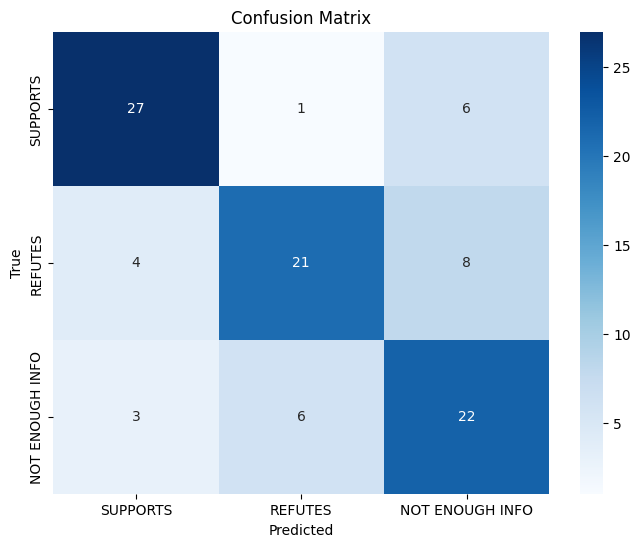

In [38]:
# Load dataset
ds = validation_1K

# Run evaluation
pred_labels,true_labels = evaluate_rag_chain_accuracy(ds, tagged_rag_chain_validate_dpo, num_samples=100)


### Here are 5 key takeaways from the DPO model's evaluation (accuracy: 70%):

- SUPPORTS is the strongest class, with high precision (0.79) and recall (0.79), indicating consistent identification of supporting evidence.

- REFUTES shows moderate recall (0.62) but good precision (0.75), suggesting some refuting claims are misclassified as NEI or SUPPORTS.

- NEI classification is decent, with 0.65 F1-score and 22/32 correct predictions, though confusion with REFUTES and SUPPORTS persists.

- Macro average F1 (0.53) is modest due to class imbalance and performance drop on REFUTES and NEI, but weighted average F1 (0.71) reflects strong performance on dominant classes.

- Confusion matrix confirms reduced misclassification overall, with clearer separation between SUPPORTS and the other two labels—demonstrating effective alignment through DPO tuning.

## === Visualizations ===

### Pie Chart for Prediction Label Distribution for RAG based output

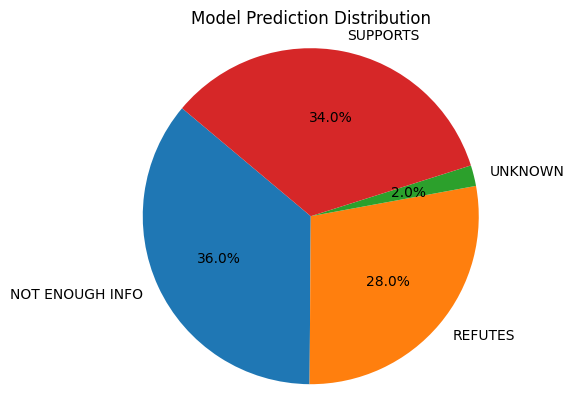

In [39]:
from collections import Counter
label_counts = Counter(pred_labels)
labels = list(label_counts.keys())
sizes = list(label_counts.values())

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title("Model Prediction Distribution")
plt.axis('equal')
plt.show()


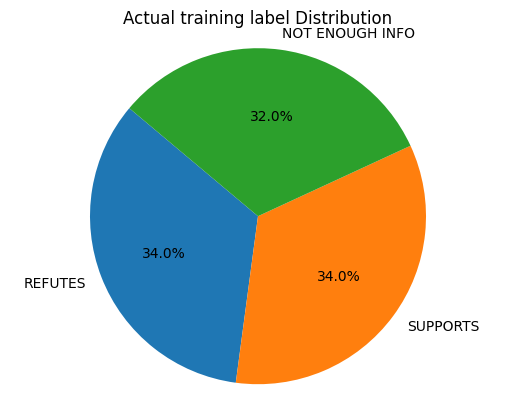

In [40]:
from collections import Counter
label_counts = Counter(true_labels)
labels = list(label_counts.keys())
sizes = list(label_counts.values())

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title("Actual training label Distribution")
plt.axis('equal')
plt.show()


### True vs Predicted Label Distribution for RAG based output

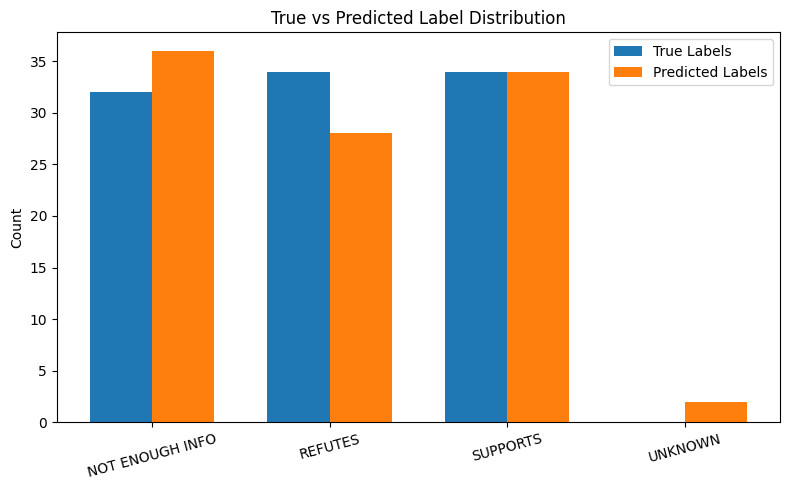

In [41]:
# Count frequencies
true_counts = Counter(true_labels)
pred_counts = Counter(pred_labels)

# Ensure consistent label order
all_labels = sorted(list(set(true_counts.keys()) | set(pred_counts.keys())))

true_values = [true_counts.get(label, 0) for label in all_labels]
pred_values = [pred_counts.get(label, 0) for label in all_labels]

# Bar plot setup
x = np.arange(len(all_labels))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, true_values, width, label="True Labels")
plt.bar(x + width/2, pred_values, width, label="Predicted Labels")

plt.ylabel("Count")
plt.title("True vs Predicted Label Distribution")
plt.xticks(x, all_labels, rotation=15)
plt.legend()
plt.tight_layout()
plt.show()


## Save DPO model in Hub

In [50]:
model_raw_trained = dpo_trainer.model
model_merged = model_raw_trained.merge_and_unload()

In [51]:
#  Push to hub
model_merged.push_to_hub(hub_save_path, safe_serialization=True)
tokenizer.push_to_hub(hub_save_path)

model.safetensors:   0%|          | 0.00/4.65G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/sauravverma78/mistral7bInstruct02_fever_dpo/commit/12f237834a372b332028b16a3a4df41b0b4338f5', commit_message='Upload tokenizer', commit_description='', oid='12f237834a372b332028b16a3a4df41b0b4338f5', pr_url=None, repo_url=RepoUrl('https://huggingface.co/sauravverma78/mistral7bInstruct02_fever_dpo', endpoint='https://huggingface.co', repo_type='model', repo_id='sauravverma78/mistral7bInstruct02_fever_dpo'), pr_revision=None, pr_num=None)

In [42]:
# # load DPO trained model from hub
# model_merged1 = AutoModelForCausalLM.from_pretrained(
#     hub_save_path, device_map="auto",
#     trust_remote_code=True,
#     torch_dtype="auto")
# tokenizer_raw1 = AutoTokenizer.from_pretrained(hub_save_path)